In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
# Model parameters
LEARNING_RATE = 1e-4
BATCH_SIZE = 32
EPOCH = 10
CLASS_NUM = 2

IMAGE_HEIGHT = 180
IMAGE_WIDTH = 180

data_dir = '../dataset'
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [3]:
# Load dataset
Transforms = transforms.Compose([
    transforms.Resize((IMAGE_HEIGHT, IMAGE_WIDTH)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = torchvision.datasets.ImageFolder(
    root=data_dir,
    transform=Transforms
)
classes = ('with_mask', 'without_mask')

In [4]:
# Split dataset
from sklearn.model_selection import train_test_split
dataset_size = len(dataset)
testing_split = 0.2
train_idx, test_idx = train_test_split(range(dataset_size),test_size=testing_split )

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

trainloader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    sampler=train_sampler
)
testloader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    sampler=test_sampler
)

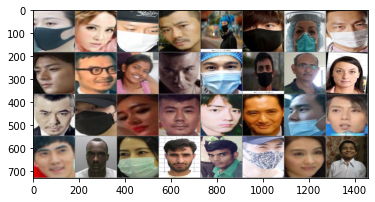

In [5]:
# Show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

In [6]:
images.shape

torch.Size([32, 3, 180, 180])

In [7]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1)),
                     
            nn.Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1)),
            
            nn.Dropout(p=0.2)
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(16 * 45 * 45, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.2),
            nn.Linear(128, 2)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas


net = Net()
net.to(DEVICE)
net.eval()

Net(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=(1, 1), ceil_mode=False)
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=(1, 1), ceil_mode=False)
    (6): Dropout(p=0.2, inplace=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=32400, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=2, bias=True)
  )
)

In [8]:
images, labels = dataiter.next()
logits, probas = net(images)
print(logits.shape)

torch.Size([32, 2])


In [9]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)

In [10]:
for epoch in range(EPOCH):  # loop over the dataset multiple times

    loop = tqdm(enumerate(trainloader), total=len(trainloader))
    for batch_idx, (data, targets) in loop:
        # get the inputs; data is a list of [data, targets]
        data = data.to(DEVICE)
        targets = targets.to(DEVICE)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        inputs, probas = net(data)
        loss = criterion(inputs, targets)
        loss.backward()
        optimizer.step()
        
        # update progress bar
        loop.set_description(f"Epoch [{epoch+1}/{EPOCH}]")
        loop.set_postfix(loss=loss.item())


print('Finished Training')

Epoch [1/10]:  28%|███████████████▊                                        | 24/85 [00:07<00:17,  3.50it/s, loss=0.526]C:\ProgramData\Anaconda3\envs\Pytorch\lib\site-packages\PIL\Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch [10/10]: 100%|███████████████████████████████████████████████████████| 85/85 [00:29<00:00,  2.86it/s, loss=0.105]

Finished Training


In [11]:
PATH = './mask_net.pth'
torch.save(net.state_dict(), PATH)

GroundTruth:  without_mask without_mask with_mask with_mask without_mask with_mask without_mask with_mask with_mask with_mask without_mask without_mask with_mask with_mask without_mask with_mask without_mask without_mask with_mask without_mask without_mask without_mask without_mask without_mask with_mask without_mask without_mask without_mask with_mask without_mask without_mask without_mask


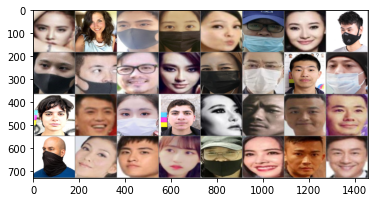

In [12]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(BATCH_SIZE)))

In [13]:
# Load Net
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [14]:
# Split dataset
from sklearn.model_selection import train_test_split
dataset_size = len(dataset)
testing_split = 0.2
train_idx, test_idx = train_test_split(range(dataset_size),test_size=testing_split )

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

trainloader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    sampler=train_sampler
)
testloader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    sampler=test_sampler
)

In [15]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images.to(DEVICE)
        labels.to(DEVICE)
        
        logits, probas = net(images)
        _, predicted = torch.max(probas, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the test images: 97 %


In [16]:
class_correct = list(0. for i in range(CLASS_NUM))
class_total = list(0. for i in range(CLASS_NUM))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images.to(DEVICE)
        labels.to(DEVICE)
        
        logits, probas = net(images)
        _, predicted = torch.max(probas, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(CLASS_NUM):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of with_mask : 93 %
Accuracy of without_mask : 100 %


In [17]:
class LayerActivations:
    features = None
 
    def __init__(self, model, layer_num):
        self.hook = model[layer_num].register_forward_hook(self.hook_fn)
 
    def hook_fn(self, module, input, output):
        self.features = output.cpu()
 
    def remove(self):
        self.hook.remove()
 
print(net.features)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=(1, 1), ceil_mode=False)
  (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU(inplace=True)
  (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=(1, 1), ceil_mode=False)
  (6): Dropout(p=0.2, inplace=False)
)


In [18]:
img = next(iter(trainloader))[0]
def showlayer(img, n):
    conv_out = LayerActivations(net.features, n)
    # imshow(img)
    o = net(img)
    conv_out.remove()
    act = conv_out.features 

    print(act[0].shape)

    fig = plt.figure(figsize=(16, 20))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=0.8, hspace=0, wspace=0.2)
    for i in range(16):
        ax = fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
        ax.imshow(act[0][i].detach().numpy(), cmap="gray")

    plt.show()

In [19]:
img = next(iter(trainloader))[0]
logits, probas = net(img)
_, predicted = torch.max(probas, 1)
print(predicted)

tensor([0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0,
        0, 1, 0, 1, 0, 1, 1, 0])
